# Gamma experiment with fixed or variable threshold

In [ ]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# loforest and locart functions
from CSI.loforest import ConformalLoforest
from CSI.scores import LambdaScore
from clover import Scores
from clover import LocartSplit
from copy import deepcopy
from tqdm import tqdm
from scipy import stats
import time
import itertools

In this case, $\Theta = (4, 10) \times (2, 8)$

In [2]:
# simulator
def sim_gamma(gamma_shape, gamma_scale, n, rng, threshold=None):
    
    random_x = rng.gamma(gamma_shape, gamma_scale, n)
    
    if not threshold:
        threshold = rng.choice(random_x)

    emp_prob = np.mean(random_x > threshold)
    t_prob = 1 - stats.gamma.cdf(threshold, a=gamma_shape, scale=gamma_scale)

    lambda_stat = np.abs(t_prob - emp_prob)

    return lambda_stat

# randomly sampling from gamma
def sample_gamma(n, N, rng, threshold = None):
    thetas = np.c_[rng.uniform(2, 8, n), rng.uniform(4, 10, n)]
    lambdas = np.zeros(n)
    i = 0
    for shape, scale in thetas:
        lambdas[i] = sim_gamma(gamma_shape=shape, 
                               gamma_scale=scale, 
                               n=N, 
                               rng =rng, 
                               threshold = threshold,
                               )
        i += 1
    return thetas, lambdas


# naive method
def naive(alpha, rng, B=1000, N=100, seed=250, naive_n=100, threshold = None):
    np.random.seed(seed)
    n_grid = round(np.sqrt(B / naive_n))
    a_s = np.linspace(4.0001, 9.9999, n_grid)
    b_s = np.linspace(2.0001, 7.9999, n_grid)
    
    quantiles = {}
    for shape, scale in itertools.product(b_s, a_s):
        lambda_stat = np.zeros(naive_n)
        for i in range(naive_n):
            lambda_stat[i] = sim_gamma(
                gamma_shape=shape, 
                gamma_scale=scale, 
                n = N, 
                rng = rng,
                threshold = threshold,
                )

        quantiles[(shape, scale)] = np.quantile(lambda_stat, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(thetas_values - x, axis=1)
        idx = thetas_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

In [3]:
def evaluate_coverage(
        quantiles_dict, 
        thetas, 
        alpha=0.05,
        n=1000, 
        N=100, 
        seed = 25, 
        threshold = None,):
    err_data = np.zeros((thetas.shape[0], 4))
    coverage_data = np.zeros((thetas.shape[0], 4))
    j = 0
    rng = np.random.default_rng(seed)
    for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
        stat = np.zeros(n)
        for i in range(0, n):
            stat[i] = sim_gamma(
                gamma_shape=theta[0], 
                gamma_scale=theta[1], 
                n=N, 
                rng = rng, 
                threshold= threshold,
                )
            
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][j])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest"][j])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][j])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][j])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))

        # saving in numpy array
        err_data[j, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
        coverage_data[j, :] = np.array(
            [locart_cover, loforest_cover, boosting_cover, naive_cover]
        )
        j += 1

    # obtaining MAE and standard error for each method
    mae_vector, std_vector = np.mean(err_data, axis=0), np.std(err_data, axis=0)
    stats_data = pd.DataFrame(
        {
            "methods": ["LOCART", "LOFOREST", "boosting", "naive"],
            "MAE": mae_vector,
            "str": std_vector / (np.sqrt(thetas.shape[0])),
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas],
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 50,
    naive_n=500,
    threshold = None
):
    # fitting and predicting naive
    naive_quantiles = naive(alpha, rng = rng, B=B, N=N, naive_n= naive_n, threshold = threshold)
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # simulating to fit models
    thetas_sim, model_lambdas = sample_gamma(n=B, N=N, rng = rng, threshold = threshold)

    model_thetas = thetas_sim.reshape(-1, 2)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=100
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators= n_estimators,
        K = K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas.reshape(-1, 2))
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 2))

    # boosting
    boosting_quantiles = model.predict(thetas.reshape(-1, 2))

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict

def evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000]),
    B=1000,
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 40,
    naive_n=100,
):
    coverage_data = np.zeros((thetas.shape[0] * N.shape[0], 4))
    N_list = []
    N_list_cover = []
    methods_list = []
    rng = np.random.default_rng(seed)
    k = 0
    j = 0

    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        # computing all quantiles for fixed N
        quantiles_dict = obtain_quantiles(
            thetas,
            N=N_fixed,
            B=B,
            alpha=alpha,
            min_samples_leaf=min_samples_leaf,
            naive_n=naive_n,
            n_estimators = n_estimators,
            K = K,
            rng = rng,
        )
        err_data = np.zeros((thetas.shape[0], 4))
        l = 0
        for theta in tqdm(thetas, desc="Computing coverage for each method"):
            stat = np.zeros(n)
            for i in range(0, n):
                stat[i] = sim_gamma(
                    gamma_shape=theta[0], 
                    gamma_scale=theta[1], 
                    n=N_fixed, 
                    rng = rng,
                    )

            # comparing coverage of methods
            locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
            loforest_cover = np.mean(stat <= quantiles_dict["loforest"][l])
            boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
            naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

            # appending the errors
            err_locart = np.abs(locart_cover - (1 - alpha))
            err_loforest = np.abs(loforest_cover - (1 - alpha))
            err_boosting = np.abs(boosting_cover - (1 - alpha))
            err_naive = np.abs(naive_cover - (1 - alpha))

            # saving in numpy array
            err_data[l, :] = np.array(
                [err_locart, err_loforest, err_boosting, err_naive]
            )

            coverage_data[j, :] = np.array(
                [locart_cover, loforest_cover, boosting_cover, naive_cover]
            )
            N_list_cover.append(N_fixed)

            l += 1
            j += 1
        methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
        if k == 0:
            mae_vector = np.mean(err_data, axis=0)
            std_vector = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
        else:
            mean = np.mean(err_data, axis=0)
            std = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
            mae_vector, std_vector = np.concatenate((mae_vector, mean)), np.concatenate(
                (std_vector, std)
            )
        k += 1

        N_list.extend([N_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "MAE": mae_vector,
            "se": std_vector,
        }
    )
    v = np.tile(thetas, (N.shape[0], 1, 1)).reshape(-1, 2)
    tiled_vector_str = np.array([' '.join(map(str, row)) for row in v])

    coverage_data = pd.DataFrame(
        {
            "thetas": list(range(0, len(coverage_data[:, 0]))),
            "N": N_list_cover,
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [4]:
N, B, alpha = 100, 1000, 0.05
rng = np.random.default_rng(125)

Fitting naive:

In [5]:
start_time = time.time()
naive_quantiles = naive(alpha = alpha, B = B, N = N, rng = rng)
end_time = time.time()

running_time = end_time - start_time
print(f"Naive running time: {running_time} seconds.")

Naive running time: 0.07195281982421875 seconds.


Sampling $\theta$ and $\lambda$ to fit the models:


In [6]:
model_thetas, model_lambdas = sample_gamma(n = B, N = N, rng = rng)

Fitting all other methods:

In [7]:
start_time = time.time()
locart_object = LocartSplit(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 100)
end_time = time.time()
print(f"LOCART running time: {end_time - start_time} seconds.")

# loforest quantiles
start_time = time.time()
loforest_object = ConformalLoforest(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
end_time = time.time()
print(f"LOFOREST running time: {end_time - start_time} seconds.")

# boosting quantiles
start_time = time.time()
model = HistGradientBoostingRegressor(loss="quantile", max_iter = 1000,
    quantile = 1 - alpha, random_state = 105, n_iter_no_change = 20, early_stopping = True)
model.fit(model_thetas, model_lambdas)
end_time = time.time()
print(f"Boosting running time: {end_time - start_time} seconds.")

LOCART running time: 0.006136655807495117 seconds.
LOFOREST running time: 0.11467719078063965 seconds.
Boosting running time: 0.09968304634094238 seconds.


Generating 2d grid for $\theta$:

In [8]:
n_out = 50
a_s = np.linspace(4.0001, 9.9999, n_out)
b_s = np.linspace(2.0001, 7.9999, n_out)
thetas_grid = np.c_[list(itertools.product(a_s, b_s))]
# printing grid size
thetas_grid.shape[0]

2500

In [9]:
# naive quantiles
naive_list = predict_naive_quantile(thetas_grid, naive_quantiles)

# locart quantiles
idxs = locart_object.cart.apply(thetas_grid)
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

# loforest
loforest_cutoffs = loforest_object.compute_cutoffs(thetas_grid)

# boosting
boosting_quantiles = model.predict(thetas_grid)

# dictionary of quantiles
quantile_dict = {
    "naive": naive_list,
    "locart": list_locart_quantiles,
    "loforest": loforest_cutoffs,
    "boosting": boosting_quantiles,
}

Testing with $N = 100$ and $B = 1000$:

In [10]:
cover_data = evaluate_coverage(
    quantile_dict, 
    thetas = thetas_grid, 
    N = 100, 
    n = 1000, 
    seed = 125,
    threshold = 30
    )

Computing coverage for each method: 100%|██████████| 2500/2500 [02:44<00:00, 15.18it/s]


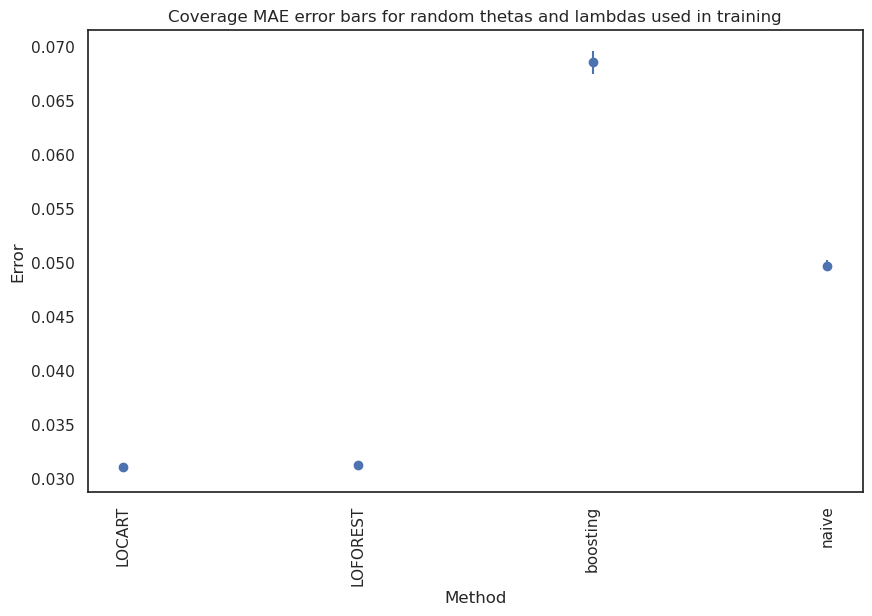

In [11]:
sns.set(style="white", font_scale=1)
keys = cover_data[0].iloc[:, 0].values
mae = cover_data[0].iloc[:, 1].values
std_err = cover_data[0].iloc[:, 2].values

plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


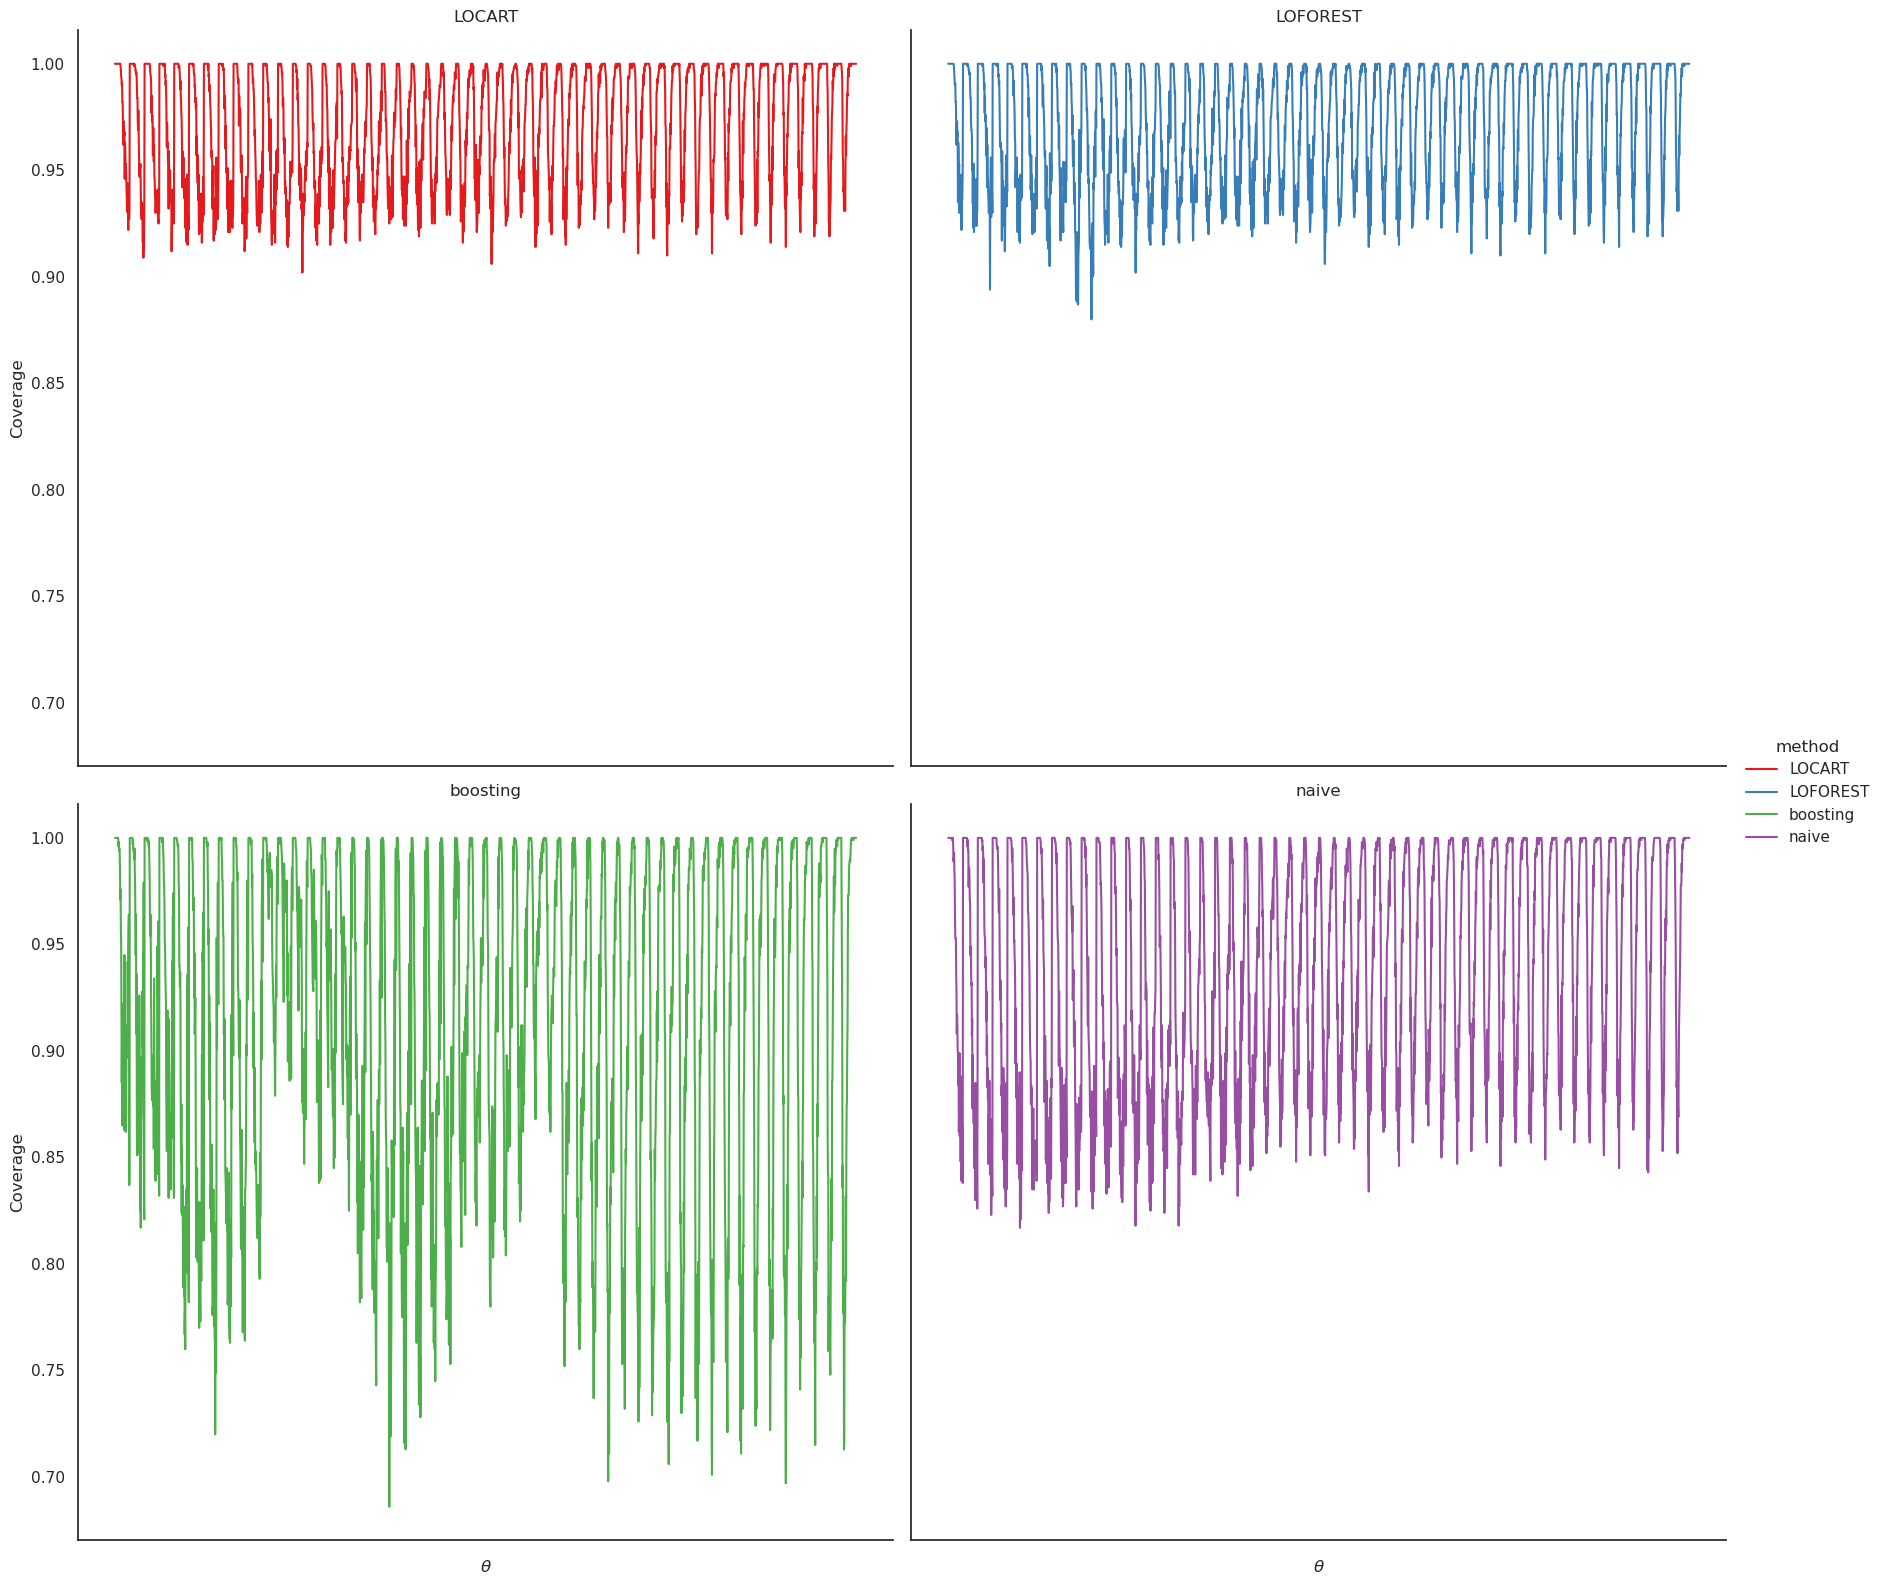

In [12]:
# Melt the coverage data
coverage_data_melted = pd.melt(
    cover_data[1], id_vars=["thetas"], var_name="method", value_name="coverage")
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(coverage_data_melted, col="method", hue = "method",
 col_wrap = 2, height=8, aspect=1.10, palette = "Set1")
g.set(xticklabels=[])
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.show()

In [13]:
# function to compute MAE stats for several B's and N's
def compute_MAE_N(
    thetas,
    N=np.array([1, 10, 100, 1000]),
    B=np.array([500, 1000, 5000, 10000, 15000]),
    alpha=0.05,
    n=1000,
    seed=45,
    n_estimators = 100,
    K = 40,
    min_samples_leaf=100,
    naive_n=100,
    threshold = None
): 
    coverage_data = np.zeros((thetas.shape[0] * N.shape[0], 4))
    N_list = []
    mae_list = []
    se_list = []
    methods_list = []
    B_list = []
    j = 0
    rng = np.random.default_rng(seed)
    for N_fixed in N:
        k = 0
        for B_fixed in B:
            print(f'Computing for B = {B_fixed} and N = {N_fixed}')
            # computing all quantiles for fixed N
            quantiles_dict = obtain_quantiles(
                thetas,
                N=N_fixed,
                B=B_fixed,
                alpha=alpha,
                min_samples_leaf=min_samples_leaf,
                n_estimators=n_estimators,
                K = K,
                naive_n=naive_n,
                rng = rng,
                threshold = threshold
            )
            err_data = np.zeros((thetas.shape[0], 4))
            l = 0
            for theta in thetas:
                # generating several lambdas
                stat = np.zeros(n)
                for i in range(0, n):
                    stat[i] = sim_gamma(
                        gamma_shape=theta[0], 
                        gamma_scale=theta[1], 
                        n=N_fixed, 
                        rng = rng,
                        threshold= threshold,
                        )
                        
                # comparing coverage of methods
                locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
                loforest_cover = np.mean(stat <= quantiles_dict["loforest"][l])
                boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
                naive_cover = np.mean(stat <= quantiles_dict["naive"][l])
        
                # appending the errors
                err_locart = np.abs(locart_cover - (1 - alpha))
                err_loforest = np.abs(loforest_cover - (1 - alpha))
                err_boosting = np.abs(boosting_cover - (1 - alpha))
                err_naive = np.abs(naive_cover - (1 - alpha))
        
                # saving in numpy array
                err_data[l, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
                coverage_data[l, :] = np.array(
                    [locart_cover, loforest_cover, boosting_cover, naive_cover]
                    )
                l += 1

            mae_list.extend(np.mean(err_data, axis = 0).tolist())
            se_list.extend((np.std(err_data, axis = 0)/np.sqrt(thetas.shape[0])).tolist())
            methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
            N_list.extend([N_fixed] * 4)
            B_list.extend([B_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [16]:
mae_stats = compute_MAE_N(
    thetas_grid,
    N=np.array([1, 50, 100, 1000]),
    B=np.array([1000, 5000, 10000, 15000]),
    naive_n= 100,
    min_samples_leaf=100,
    n_estimators = 200,
    K = 50,
    seed=45,
    threshold = 30,
)

Computing for B = 1000 and N = 1
Computing for B = 5000 and N = 1
Computing for B = 10000 and N = 1
Computing for B = 15000 and N = 1
Computing for B = 1000 and N = 50
Computing for B = 5000 and N = 50
Computing for B = 10000 and N = 50
Computing for B = 15000 and N = 50
Computing for B = 1000 and N = 100
Computing for B = 5000 and N = 100
Computing for B = 10000 and N = 100
Computing for B = 15000 and N = 100
Computing for B = 1000 and N = 1000
Computing for B = 5000 and N = 1000
Computing for B = 10000 and N = 1000
Computing for B = 15000 and N = 1000


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

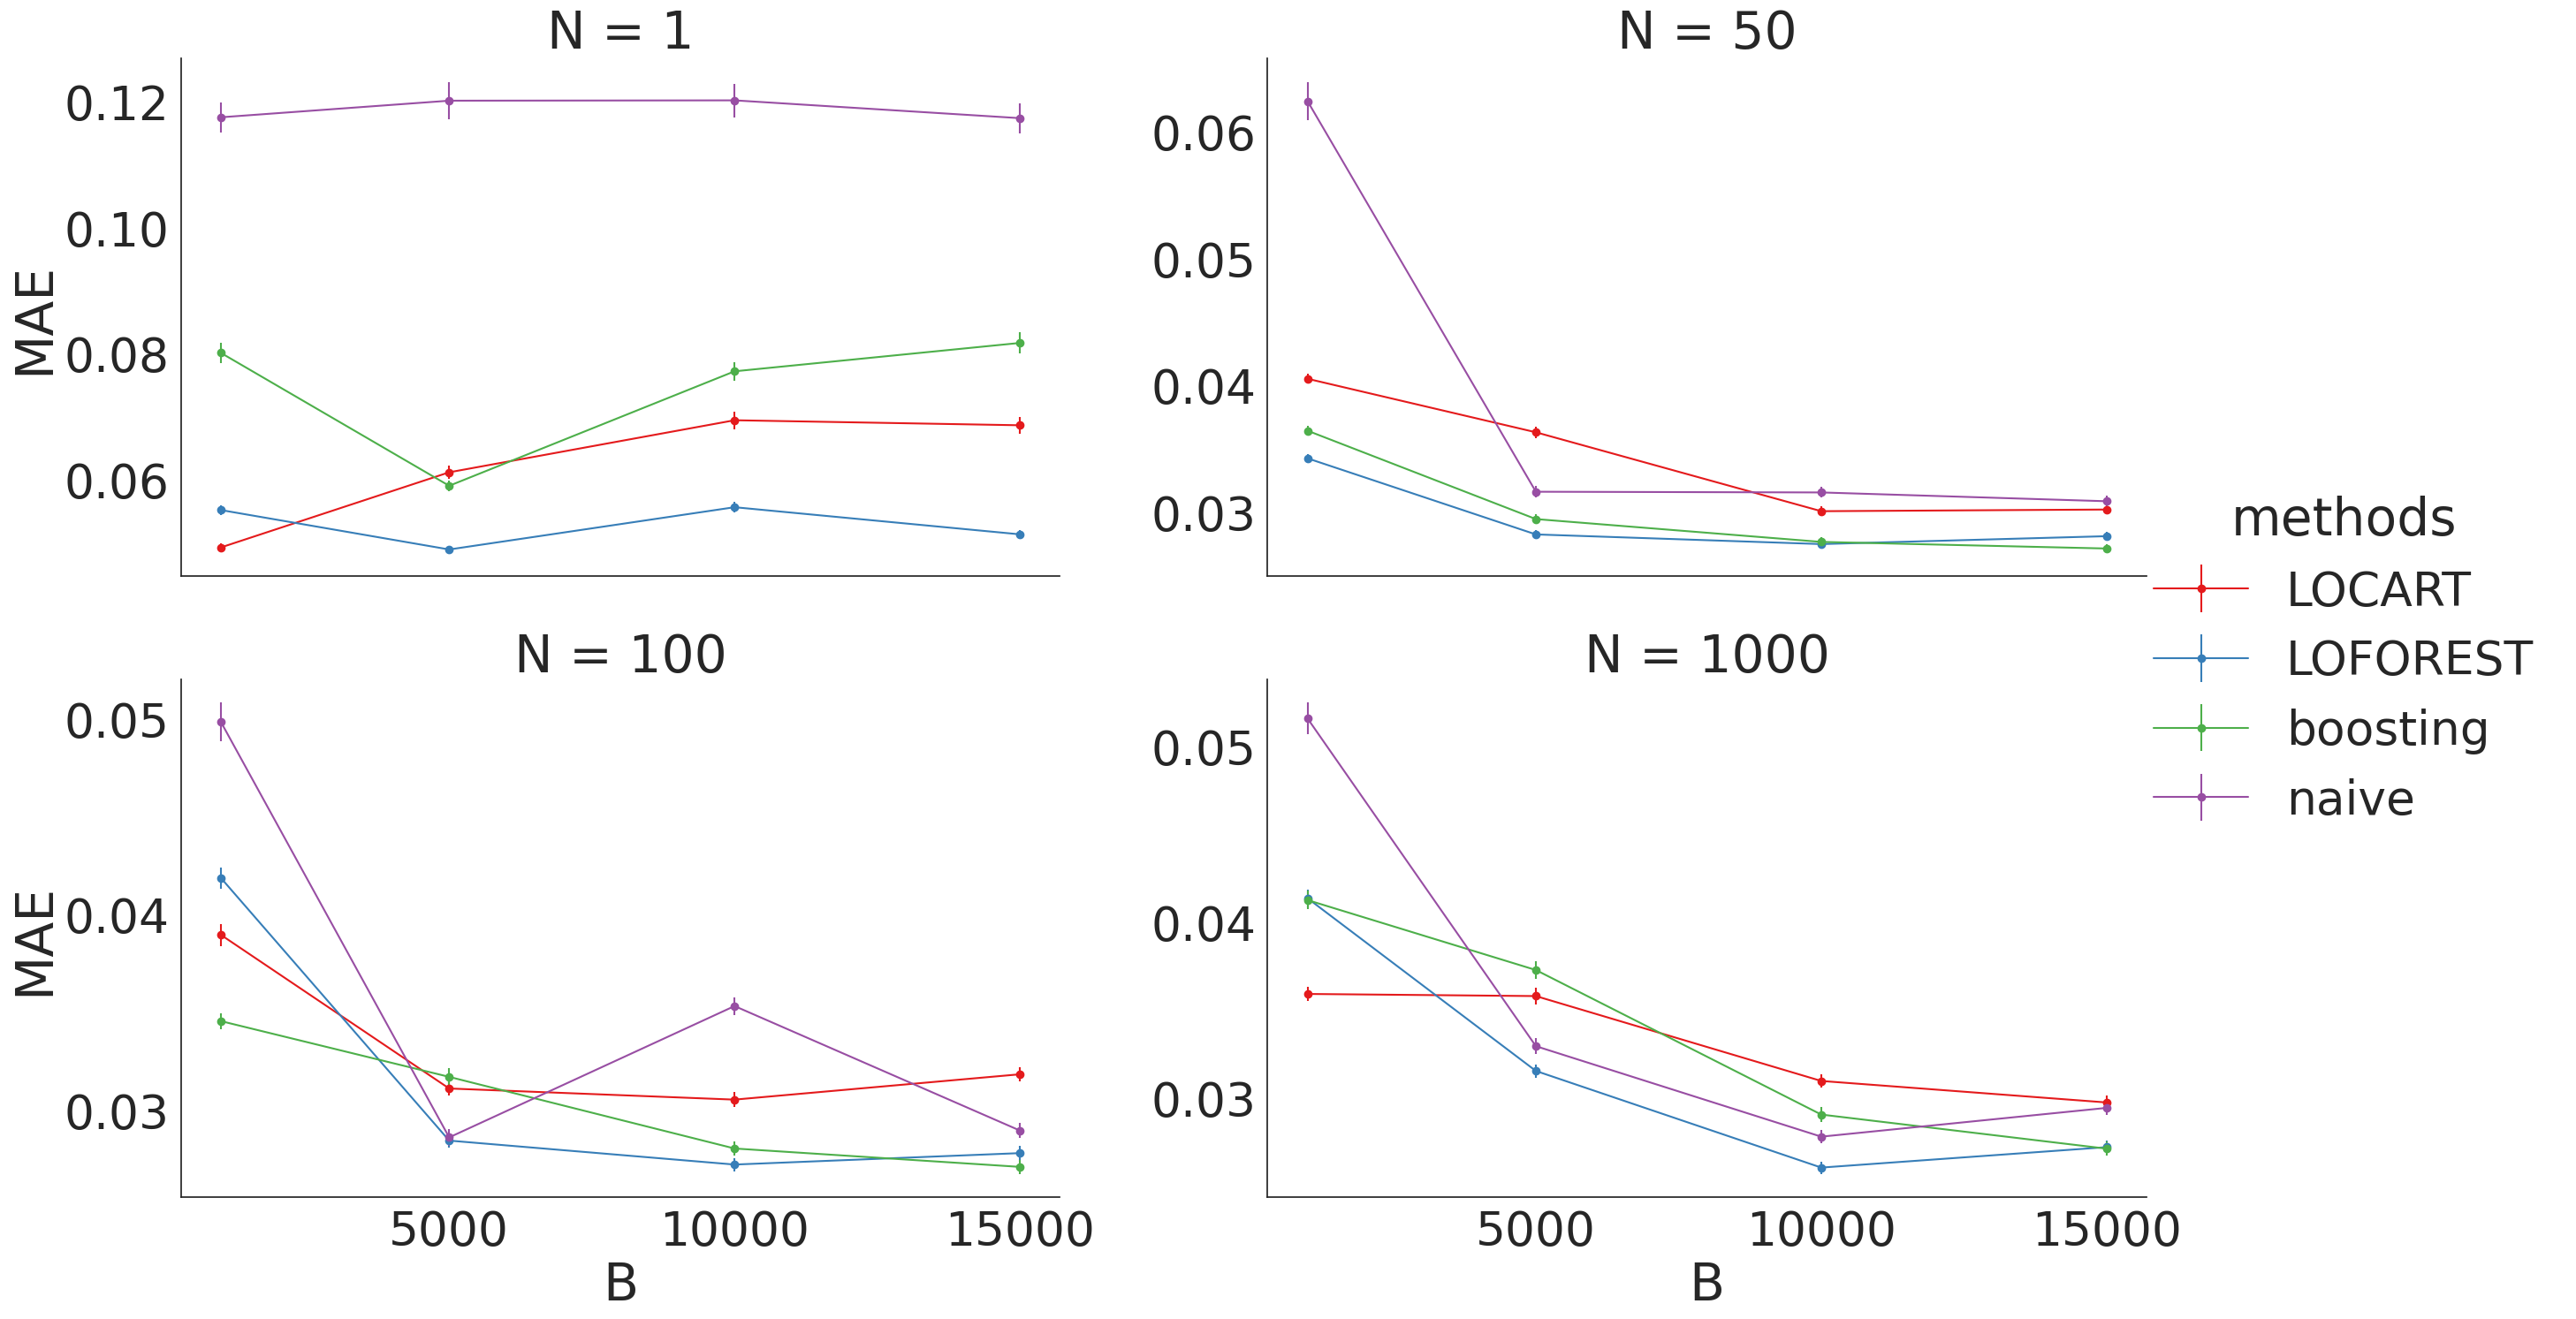

In [17]:
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()

In [22]:
coverage_data_N_1000 = evaluate_coverage_N(thetas_grid, B = 1000, naive_n = 100, n = 1000, 
                                           min_samples_leaf = 100, n_estimators = 200)

Computing coverage for each N: 100%|██████████| 3/3 [11:49<00:00, 236.55s/it]


/tmp/ipykernel_60285/582826756.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


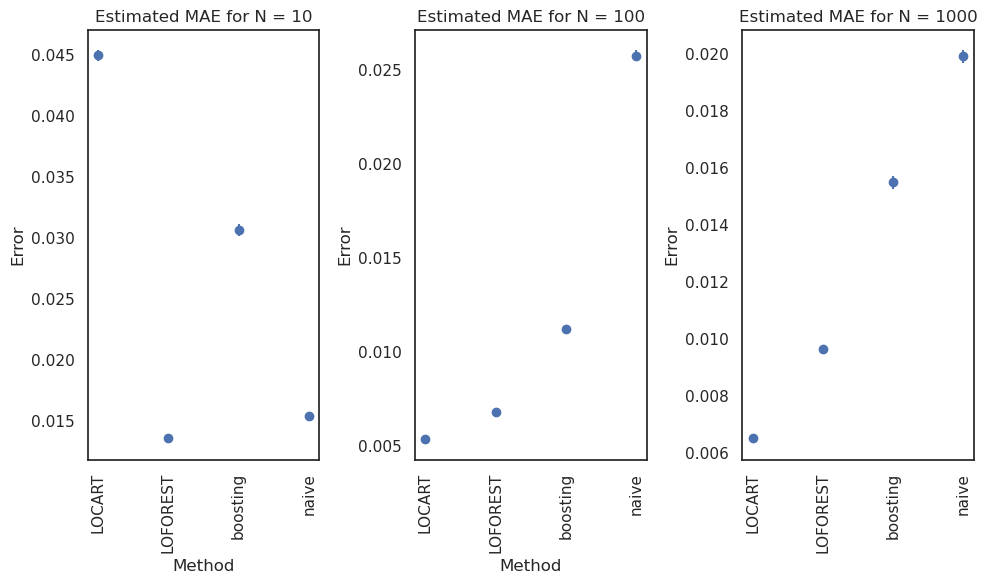

In [23]:
sns.set(style="white", font_scale=1)
fig, ax = plt.subplots(ncols=3, figsize=(10, 6))
# data for first subplot
data_10 = coverage_data_N_1000[0].query("N == 10")
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[0].set_xlabel("Method")
ax[0].set_ylabel("Error")
ax[0].set_title("Estimated MAE for N = 10")


data_100 = coverage_data_N_1000[0].query("N == 100")
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[1].set_xlabel("Method")
ax[1].set_ylabel("Error")
ax[1].set_title("Estimated MAE for N = 100")


data_1000 = coverage_data_N_1000[0].query("N == 1000")
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[2].set_ylabel("Error")
ax[2].set_title("Estimated MAE for N = 1000")

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_60285/3041673628.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


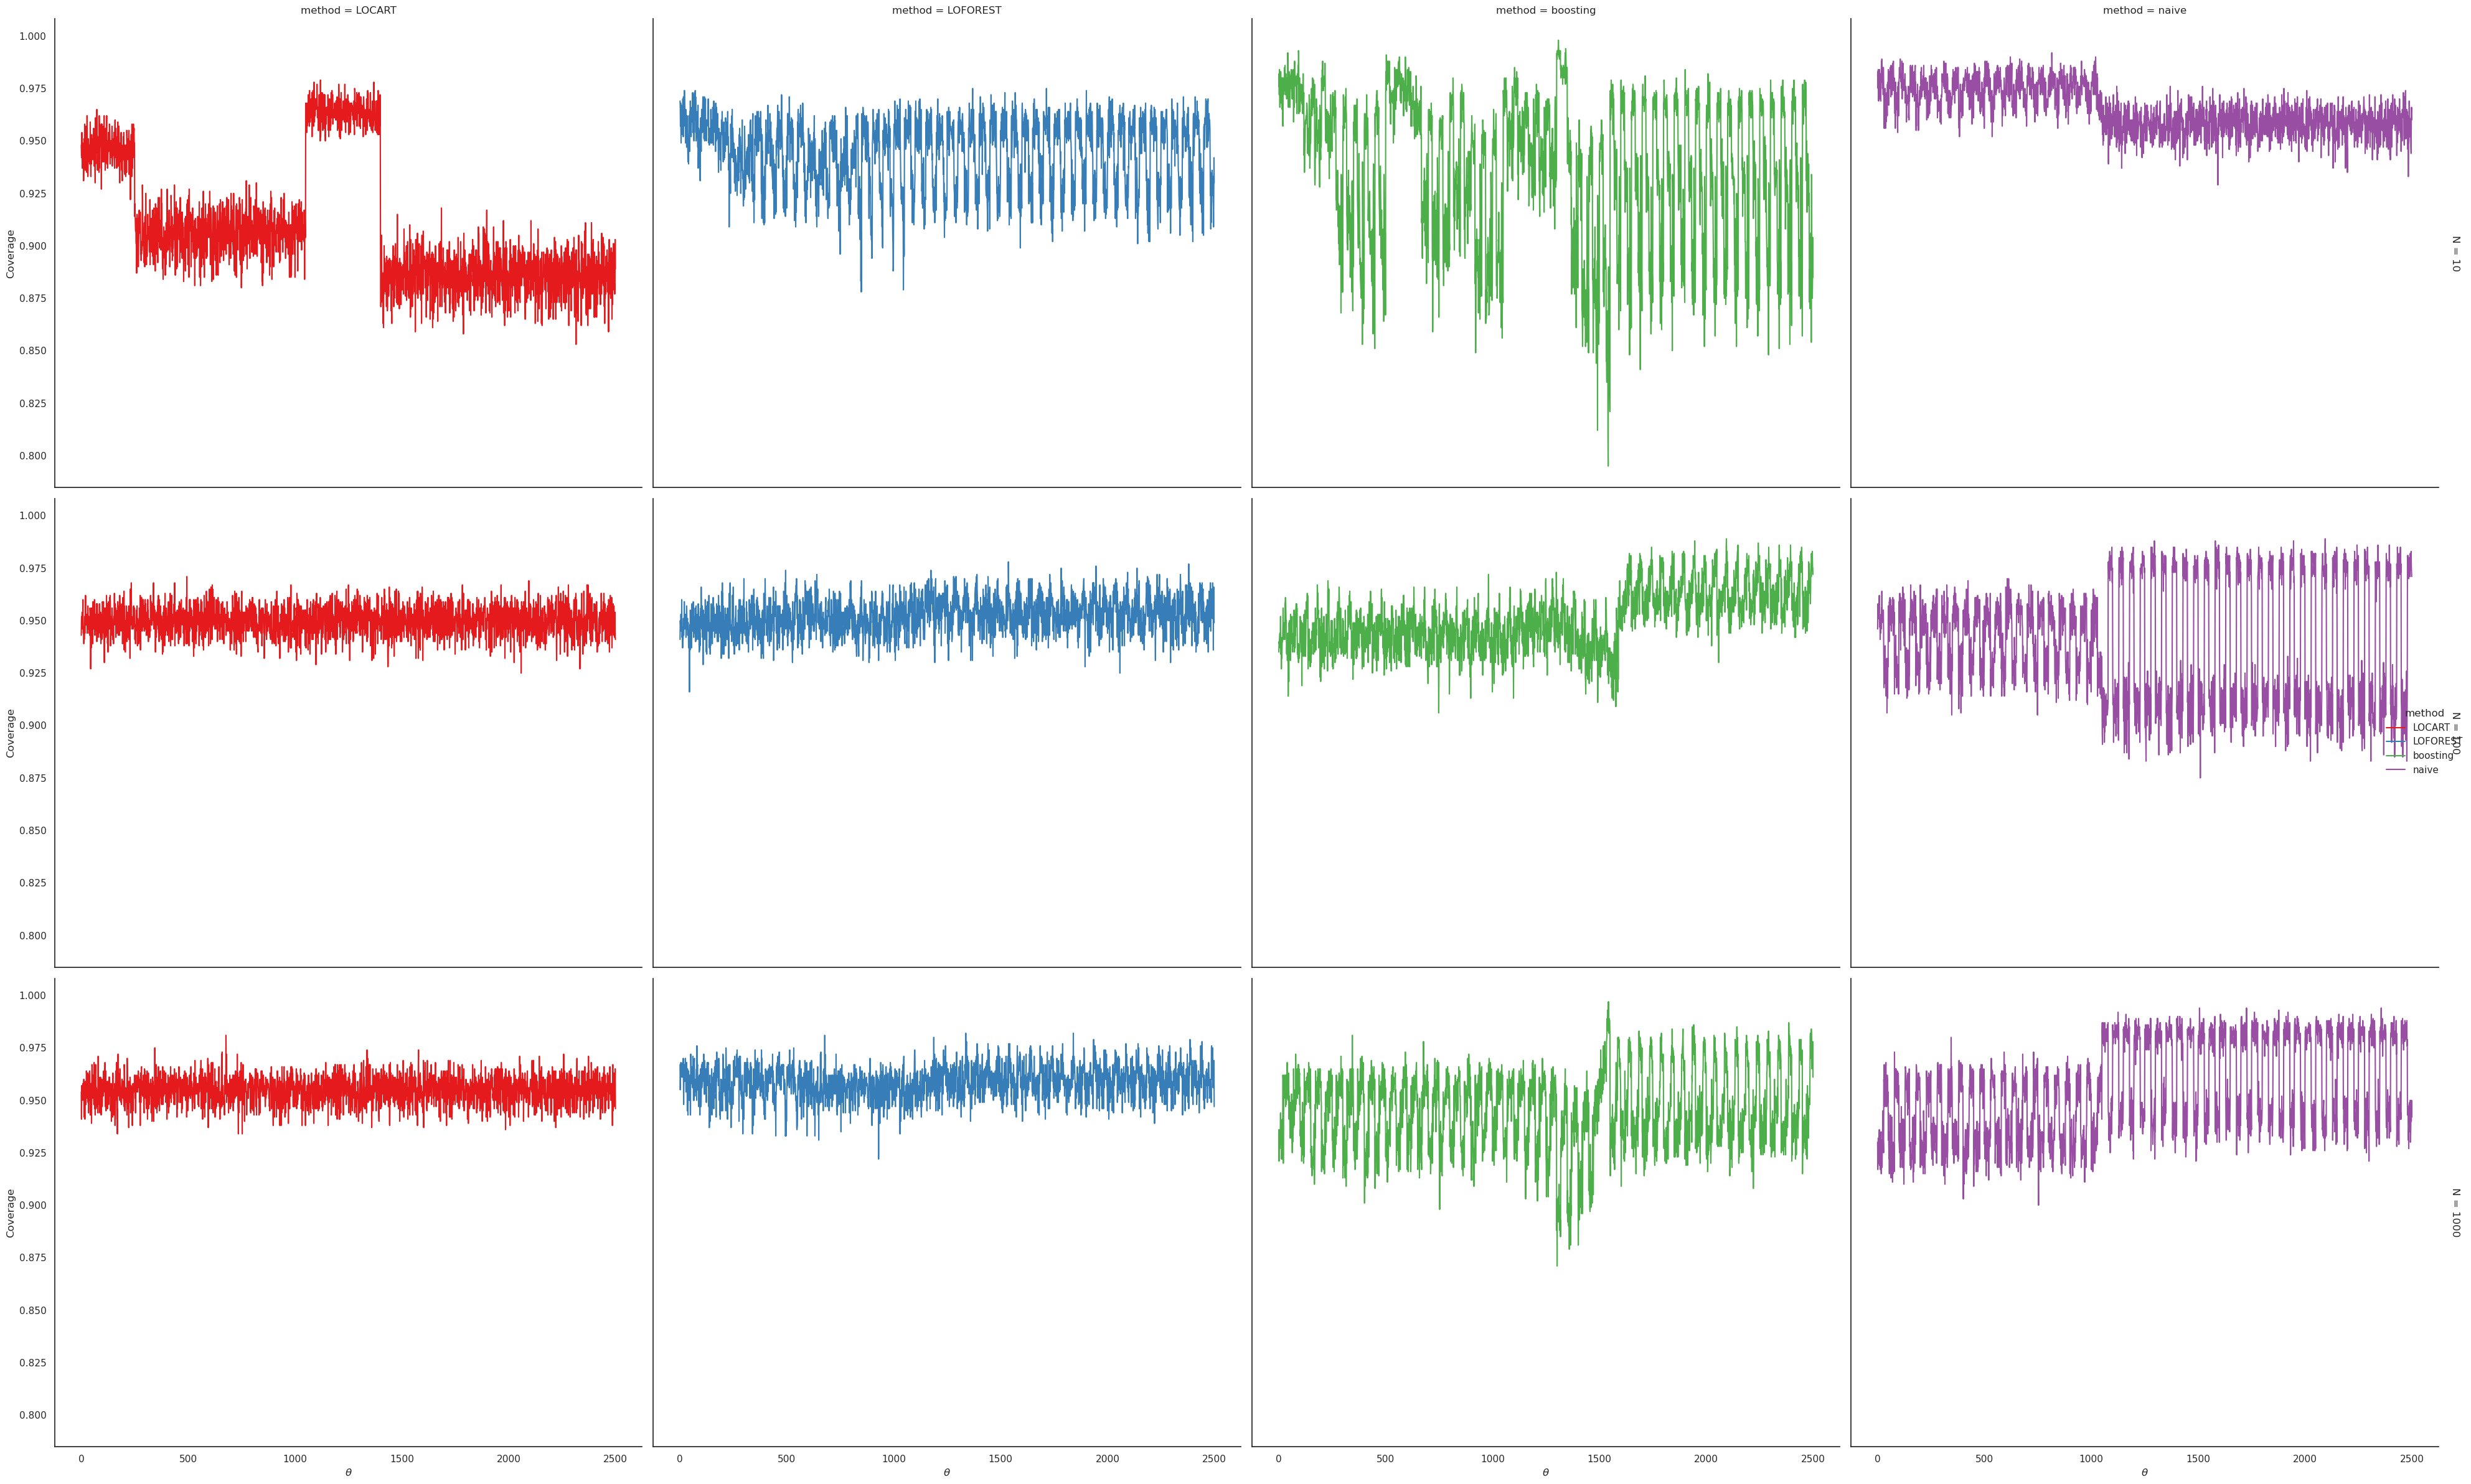

In [24]:
coverage_data_N_1000[1]['new_column'] = coverage_data_N_1000[1].index % 2500
coverage_data_N_1000[1]["thetas"] = coverage_data_N_1000[1]["new_column"]
coverage_data_N_1000[1].drop("new_column", axis=1, inplace=True)
coverage_data_melted = pd.melt(
    coverage_data_N_1000[1],
    id_vars=["thetas", "N"],
    var_name="method",
    value_name="coverage",
 )

coverage_data_melted = coverage_data_melted[coverage_data_melted["method"] != "new_column"]
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(
    coverage_data_melted,
    row="N",
    col="method",
    hue="method",
    height= 8,
    aspect=1.20,
    palette="Set1",
    margin_titles=True,
)
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.tight_layout()
plt.show()